# Install OpenQuake

In [1]:
%%capture
!pip install openquake.engine

# **Import libraries / paths**

In [2]:
import openquake
import configparser
import os
from pathlib import Path
import configparser

In [3]:
folder = Path('/Users/alex/Dropbox/Work/Repository/OpenQuake')

In [4]:
os.chdir(folder)
!pwd

/Users/alex/Dropbox/Work/Repository/OpenQuake


In [5]:
!ls

OpenQuake_FFE.ipynb
OpenQuake_TEST.ipynb
gmpe_logic_tree-CVH_BNZSEE_0317-simple-LHC.xml
job.ini
job_EventBasedPSHA.ini
rSHM_source-model_bk-NZBCK615_fl-F010519_mMin5pt0.xml
source_model_logic_tree.xml
vs30Polygoncentroids.xml


# Run OpenQuake

***Shell commands seems to be working using the ! symbol - might be possible to run OpenQuake directly from GoogleColab***


---



In [6]:
# !oq engine --help

In [8]:
!oq engine --run job_EventBasedPSHA.ini --exports csv

[2020-08-20 04:27:34 #3 INFO] alex running /Users/alex/Dropbox/Work/Repository/OpenQuake/job_EventBasedPSHA.ini [--hc=None]
[2020-08-20 04:27:34 #3 INFO] Using engine version 3.9.0
[2020-08-20 04:27:36 #3 WARNING] Using 4 cores on Alexandres-MBP
[2020-08-20 04:27:36 #3 INFO] Checksum of the input files: 178967426
[2020-08-20 04:27:36 #3 INFO] Reading the risk model if present
[2020-08-20 04:27:36 #3 INFO] Extracting the hazard sites from the site model
[2020-08-20 04:27:36 #3 INFO] Read N=76 hazard sites and L=50 hazard levels
[2020-08-20 04:27:37 #3 INFO] Validated source_model_logic_tree.xml in 0.30 seconds
[2020-08-20 04:27:37 #3 INFO] Potential number of logic tree paths = 32
[2020-08-20 04:27:37 #3 INFO] 1 effective smlt realization(s)
[2020-08-20 04:27:37 #3 INFO] Reading the source model(s) in parallel
[2020-08-20 04:29:53 #3 INFO] read_source_model 0 B sent, 1 submitted, 0 queued
[2020-08-20 04:29:55 #3 INFO] read_source_model 100% [1 submitted, 0 queued]
[2020-08-20 04:29:55 #

# Manage Outputs

In [15]:
folder

PosixPath('/Users/alex/Dropbox/Work/Repository/OpenQuake')

In [16]:
output = folder / 'output'
os.listdir(output)

['sitemesh_1.csv',
 'hazard_curve-mean-PGA_1.csv',
 'gmf-data_1.csv',
 'events_1.csv',
 'ruptures_1.csv',
 'sigma_epsilon_1.csv',
 'quantile_curve-0.5-PGA_1.csv']

## import libraries

In [17]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler

#contextily
!pip3 install contextily

CPU times: user 221 ms, sys: 76.7 ms, total: 298 ms
Wall time: 57.5 s


In [19]:
import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn import preprocessing
import contextily as ctx
import seaborn as sns

plt.style.use('seaborn-colorblind')

## check outputs

In [41]:
hzdCurves = pd.read_csv(output / 'hazard_curve-mean-PGA_1.csv', header = 1)
events = pd.read_csv(output / 'events_1.csv')
gmf = pd.read_csv(output / 'gmf-data_1.csv')

In [42]:
len(hzdCurves)

76

In [43]:
hzdCurves.iloc[:5,:]

,lon,lat,depth,poe-0.0050000,poe-0.0057376,poe-0.0065840,poe-0.0075552,poe-0.0086698,poe-0.0099487,poe-0.0114163,...,poe-0.6173704,poe-0.7084434,poe-0.8129511,poe-0.9328756,poe-1.0704911,poe-1.2284072,poe-1.4096188,poe-1.6175622,poe-1.8561809,poe-2.1300000
0,174.82111,-41.1643,0.0,0.833193,0.808757,0.781285,0.751626,0.718069,0.682981,0.644750,...,0.001062,0.000718,0.000515,0.000406,0.000234,0.000156,0.000094,0.000047,0.000031,0.000031
1,174.72530,-41.2838,0.0,0.825157,0.799854,0.771339,0.740943,0.707748,0.671942,0.634291,...,0.001483,0.001108,0.000843,0.000578,0.000453,0.000297,0.000219,0.000172,0.000125,0.000109
2,174.78860,-41.2526,0.0,0.826287,0.800965,0.772270,0.742173,0.708962,0.672778,0.634023,...,0.001389,0.000937,0.000703,0.000547,0.000359,0.000250,0.000156,0.000062,0.000047,0.000031
3,174.80280,-41.2495,0.0,0.827074,0.802082,0.774298,0.742767,0.709098,0.673067,0.633162,...,0.001264,0.000874,0.000625,0.000500,0.000344,0.000187,0.000172,0.000141,0.000109,0.000062
4,174.76871,-41.2825,0.0,0.825176,0.799988,0.772214,0.741812,0.707932,0.671687,0.632819,...,0.001327,0.000859,0.000578,0.000406,0.000266,0.000141,0.000125,0.000062,0.000047,0.000016


In [26]:
gmf.head()

,event_id,rup_id,rlz_id,year,ses_id
0,0,0,8,1,872
1,1,0,8,1,954
2,2,0,8,1,1164
3,3,0,8,1,1876
4,4,0,9,1,1364


In [27]:
events.head()

,event_id,rup_id,rlz_id,year,ses_id
0,0,0,8,1,872
1,1,0,8,1,954
2,2,0,8,1,1164
3,3,0,8,1,1876
4,4,0,9,1,1364


In [44]:
def getHazCurves(hazCurveFile, IMs=None, row=0):
    """
    Input: OQ hazard curve file, IMs targets (array), row number (linked to site)
    Output: IMs array, hazPoes (corresponding probability of exceedences),
    hazRates (corresponding rate of hazard - PDF )
    """
    if IMs is None:
        IMs=np.arange(0,10,0.01)
    # HAZARD CURVE
    fName = hazCurveFile
    df = hzdCurves
    # df = pd.read_csv(fName, header=1)
    # Reformat columns names
    oqIMs = [x.split('-')[-1] for x in df.columns[3:]]
    oqIMs = [float(x) for x in oqIMs]
    # Interp haz poes at IMs
    hazPoes=np.interp(IMs, oqIMs, df.loc[row][3:])
    # Calculate the rate of each IM
    hazRates=[hazPoes[i]-hazPoes[i+1] for i in range(0,len(hazPoes)-1)]

    return IMs, hazPoes, hazRates

In [45]:
IMrange = np.arange(0, 1, 0.1)
IM, Poes, Rates = getHazCurves(hzdCurves, IMs=IMrange)

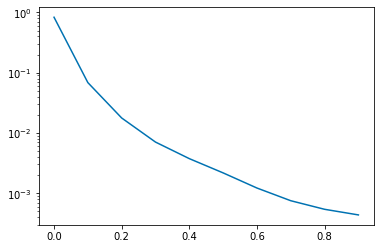

In [46]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
ax1.plot(IM, Poes)
ax1.set_yscale("log")
ax1.set